# RL and Advanced DL: Домашнее задание 3
Третье домашнее задание посвящено порождающим моделям, а точнее — порождающим состязательным сетям. Это самое маленькое и самое техническое задание в курсе, но что уж поделать. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:


In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

!tar -xf facades.tar.gz

--2021-12-28 23:16:01--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.8’

facades.tar.gz.8    100%[===================>]  28.77M  3.77MB/s    in 7.4s    

2021-12-28 23:16:09 (3.88 MB/s) - ‘facades.tar.gz.8’ saved [30168306/30168306]



In [ ]:
import os
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import tqdm
import random
import numpy as np

In [ ]:
MU = 0.
EPS = 1.0

In [ ]:
class FacadesDataset(Dataset):
    
    def __init__(self, folder='facades/train', validation=False):
        self.folder = folder
        self.files = [os.path.join(folder, f) for f in os.listdir(self.folder) if f.endswith('.jpg')]
        if validation:
            self.transforms = transforms.Compose([
                transforms.RandomCrop(256),
                transforms.ToTensor(),
                # transforms.Normalize(mean=(MU, MU, MU), std=(EPS, EPS, EPS))
            ])
        else:
            self.transforms = transforms.Compose([
                transforms.Resize([286, 286], transforms.InterpolationMode.BICUBIC),
                transforms.RandomCrop(256),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                # transforms.Normalize(mean=(MU, MU, MU), std=(EPS, EPS, EPS))
            ])
        
    def __getitem__(self, idx):
        imgs = Image.open(self.files[idx]).convert("RGB")
        img_template, img_original = imgs.crop((256, 0, 512, 256)), imgs.crop((0, 0, 256, 256))

        seed = torch.seed()

        torch.manual_seed(seed)
        img_original = self.transforms(img_original)
        torch.manual_seed(seed)
        img_template = self.transforms(img_template)

        return img_template, img_original
        
    def __len__(self):
        return len(self.files)


train_dataset = FacadesDataset(folder='facades/train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = FacadesDataset(folder='facades/val', validation=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

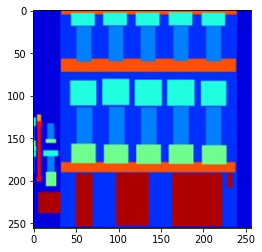

In [ ]:
#check_dataset
plt.imshow(train_dataset[0][0].squeeze().permute(1,2,0) * EPS + MU)
plt.show()

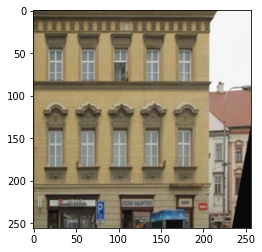

In [ ]:
plt.imshow(train_dataset[0][1].squeeze().permute(1,2,0) * EPS + MU)
plt.show()

In [ ]:
def init_conv_weight_normal(unit, mean=0., std=0.02):
    unit.weight.data.normal_(mean, std)
    unit.bias.data.zero_()

In [ ]:
class DownConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel=4, stride=2, padding=1, batchnorm=True, dropout=None):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel, stride, stride)
        self.conv.apply(init_conv_weight_normal)
        self.batchnorm = batchnorm

In [ ]:
class ConvBlock(nn.Module):
    activation_funcs = {
        'Leaky': nn.LeakyReLU(0.2),
        'Relu': nn.ReLU()
    }
    conv_types = {
        'Conv': nn.Conv2d,
        'DeConv': nn.ConvTranspose2d
    }
    
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, padding=1, batchnorm=True, dropout=None, func='Leaky', conv_type='Conv'):
        super().__init__()
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.conv = self.conv_types[conv_type]
        if dropout is not None:
            self.dropout = nn.Dropout2d(dropout)
        
        self.conv_1 = self.conv(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=padding)
        self.conv_1.apply(init_conv_weight_normal)
        self.act_func = self.activation_funcs[func]
        
        # self.batchnorm_module = nn.BatchNorm2d(out_channels)
        self.batchnorm_module = nn.InstanceNorm2d(out_channels)
        # self.batchnorm_module.apply(init_conv_weight_normal)
        
    def forward(self, x):
        y = self.conv_1(x)
        y = self.batchnorm_module(y) if self.batchnorm else y
        y = self.act_func(y)
        y = self.dropout(y) if self.dropout is not None else y
        
        return y

In [ ]:
class ImgGenerator(nn.Module):
    def __init__(self, in_chanels, out_chanels, dropout_rate=0.5):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.encoder = nn.ModuleList([
            ConvBlock(in_chanels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256, ),
            ConvBlock(256, 256, ),
            # ConvBlock(256, 512, ),
            ConvBlock(256, 512, ),
            ConvBlock(512, 512, batchnorm=False)
        ])
        
        self.decoder = nn.ModuleList([
            ConvBlock(512 + 512, 512, func='Relu', conv_type='DeConv',),
            # ConvBlock(512 + 512, 512, func='Relu', conv_type='DeConv'),
            ConvBlock(256 + 512, 256, func='Relu', conv_type='DeConv', dropout=self.dropout_rate),
            ConvBlock(256 + 256, 256, func='Relu', conv_type='DeConv'),
            ConvBlock(256 + 128, 128, func='Relu', conv_type='DeConv', dropout=self.dropout_rate),
            ConvBlock(128 + 64, 64, func='Relu', conv_type='DeConv'),
            ConvBlock(64, out_chanels, func='Relu', conv_type='DeConv', batchnorm=False, kernel=3),
        ])
        
    def forward(self, x):
        
        enc_list = list()
#         enc = self.encoder[0](enc)
#         enc_list.append(enc)
        enc = x
        for i in range(len(self.encoder)):
            enc = self.encoder[i](enc)
            enc_list.append(enc)
            
#         enc = torch.cat([enc, enc[-2]], axis=1)
#         dec = self.decoder[0](enc)
        dec = enc_list[-1]
        for i in range(len(self.decoder) - 1):
            # print(dec.shape)
            enc_idx = len(self.decoder) - i - 2
            dec = torch.cat([dec, enc_list[enc_idx]], axis=1)
            dec = self.decoder[i](dec)
            
        dec = self.decoder[-1](dec)
        # print(dec.shape)
        
        return self.tanh(dec)

Модель Pix2Pix - обучает генератор и дискриминатор

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import gc
# del model
torch.cuda.empty_cache()
gc.collect()

4753

In [ ]:
!nvidia-smi

Tue Dec 28 23:16:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    34W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## CycleGAN
### Часть вторая: добавим циклы

Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом (подробнее см. лекцию и собственно Zhu et al., 2017):


In [ ]:
class DiscriminatorSinglePix(nn.Module):

    def __init__(self, in_channels=3):
        super().__init__()
        
        self.model = nn.Sequential(
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
            nn.Conv2d(512, 1, kernel_size=4)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
class CycleGAN:
    def __init__(self, device, in_channels=3, out_channels=3, g_lr=3e-4, d_lr=2e-4):

        self.Gx = ImgGenerator(in_channels, out_channels)
        self.Gy = ImgGenerator(in_channels, out_channels)
        self.Dx = DiscriminatorSinglePix(in_channels)
        self.Dy = DiscriminatorSinglePix(in_channels)

        
        self.device = device
        self.Gx.to(self.device)
        self.Gy.to(self.device)
        self.Dx.to(self.device)
        self.Dy.to(self.device)


        self.discriminator_criterion = nn.BCEWithLogitsLoss()
        self.generator_criterion = nn.L1Loss()
        
        self.g_optimizer = torch.optim.Adam(list(self.Gx.parameters()) + list(self.Gy.parameters()), lr=g_lr)
        self.d_optimizer = torch.optim.Adam(list(self.Dx.parameters()) + list(self.Dy.parameters()), lr=d_lr)

    def train_epoch(self, dataloader):
        loss_g_l, loss_d_l = list(), list()
        for batch in dataloader:
            x, y = batch
            x = x.to(self.device)
            y = y.to(self.device)

            self.Gx.eval()
            self.Gy.eval()
            self.Dx.train()
            self.Dy.train()

            # with torch.no_grad():
                # y_fake_no_grad = self.Gx(x)
                # x_fake_no_grad = self.Gy(y)
            y_fake = self.Gx(x)
            x_fake = self.Gy(y)
            
            # update Discriminator
            self.d_optimizer.zero_grad() 
            
            x_fake_logits = self.Dx(x_fake.detach())
            x_logits = self.Dx(x)

            y_fake_logits = self.Dy(y_fake.detach())
            y_logits = self.Dy(y)

            
            x_fake_loss = self.discriminator_criterion(x_fake_logits, torch.zeros_like(x_fake_logits))
            x_real_loss = self.discriminator_criterion(x_logits, torch.ones_like(x_logits))
            loss_Dx = (x_real_loss + x_fake_loss) / 2

            y_fake_loss = self.discriminator_criterion(y_fake_logits, torch.zeros_like(y_fake_logits))
            y_real_loss = self.discriminator_criterion(y_logits, torch.ones_like(y_logits))
            loss_Dy = (y_real_loss + y_fake_loss) / 2

            loss_d = loss_Dx + loss_Dy
            
            loss_d.backward()
            self.d_optimizer.step()
            
            loss_d_l.append(loss_d.detach().cpu().item())
            
            # update G
            self.Gx.train()
            self.Gy.train()
            self.Dx.eval()
            self.Dy.eval()
            self.g_optimizer.zero_grad()

            
            y_rec = self.Gx(x_fake)
            x_rec = self.Gy(y_fake)

            g_loss_rec = 10 * self.generator_criterion(x, x_rec) + 10 * self.generator_criterion(y, y_rec)
            g_loss_fake = 10 * self.generator_criterion(x, x_fake) + 10 * self.generator_criterion(y, y_fake)

            x_fake_logits = self.Dx(x_fake)
            y_fake_logits = self.Dy(y_fake)

            gx_d_loss = self.discriminator_criterion(x_fake_logits, torch.ones_like(x_fake_logits))
            gy_d_loss = self.discriminator_criterion(y_fake_logits, torch.ones_like(x_fake_logits))

            g_loss = g_loss_rec + g_loss_fake + gx_d_loss + gy_d_loss
            

            g_loss.backward()
            self.g_optimizer.step()  
            
            loss_g_l.append(g_loss.detach().cpu().item())
            
            
        mean_loss_g = np.mean(loss_g_l)
        mean_loss_d = np.mean(loss_d_l)
        return mean_loss_g, mean_loss_d





In [ ]:
def display_progress(x, x_fake, y, y_fake, figsize=(10,5)):
    with torch.no_grad():
        x = x.cpu().permute(1, 2, 0) * EPS + MU
        x_fake = x_fake.cpu().permute(1, 2, 0) * EPS + MU
        y = y.cpu().permute(1, 2, 0) * EPS + MU
        y_fake = y_fake.cpu().permute(1, 2, 0) * EPS + MU

    fig, ax = plt.subplots(1, 4, figsize=figsize)
    ax[0].imshow(x)
    ax[1].imshow(x_fake)
    ax[2].imshow(y)
    ax[3].imshow(y_fake)
    plt.show()

In [ ]:
model_cycle_gan = CycleGAN(device)

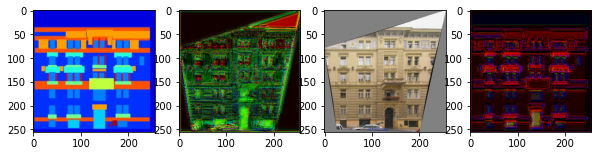

In [ ]:
with torch.no_grad():
  x, y = val_dataset[random.randrange(len(val_dataset))]
  y_fake = model_cycle_gan.Gx(x.unsqueeze(0).to(device))
  x_fake = model_cycle_gan.Gy(y.unsqueeze(0).to(device))
  display_progress(x, x_fake[0], y, y_fake[0])

  0%|          | 0/49 [00:00<?, ?it/s]

1 10.170912636518478 1.090018270611763


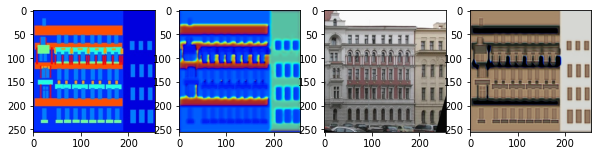

  2%|▏         | 1/49 [11:57<9:33:39, 717.07s/it]

2 10.142136759757996 1.0086184921115637


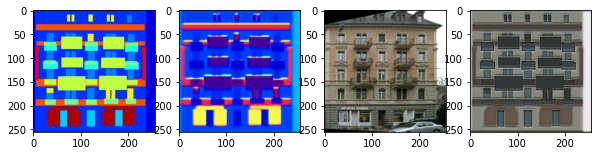

  4%|▍         | 2/49 [23:53<9:21:28, 716.77s/it]

3 10.426713709831239 0.9160655555874109


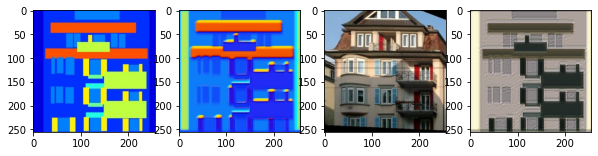

  6%|▌         | 3/49 [35:50<9:09:28, 716.71s/it]

4 10.315322473049164 0.9446928144246339


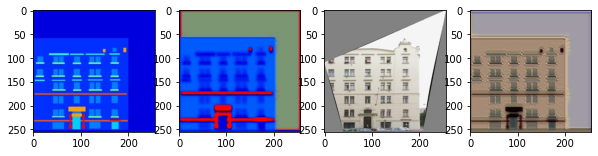

  8%|▊         | 4/49 [47:47<8:57:38, 716.85s/it]

5 10.519978576898575 0.9648493517190218


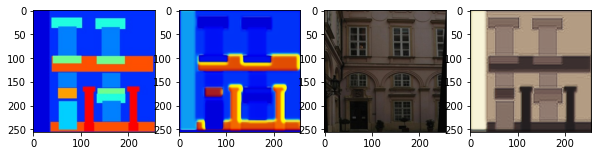

 10%|█         | 5/49 [59:44<8:45:47, 717.00s/it]

6 11.448314572572707 0.8854334568977356


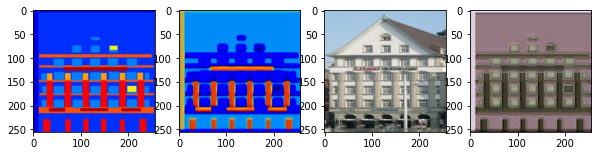

 12%|█▏        | 6/49 [1:11:41<8:33:49, 716.96s/it]

7 12.523073024749756 0.7486801160126925


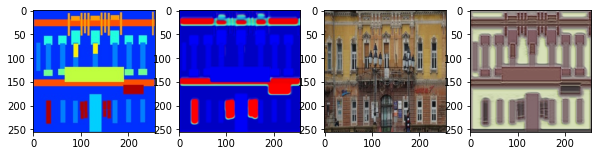

 14%|█▍        | 7/49 [1:23:38<8:21:50, 716.93s/it]

8 11.935410449504852 0.8144768327474594


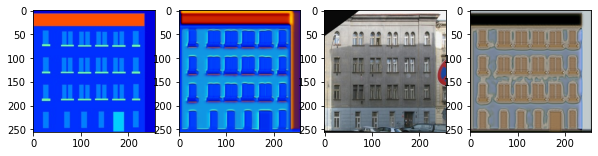

 16%|█▋        | 8/49 [1:35:35<8:09:58, 717.04s/it]

9 11.246926138401031 0.8543366747349501


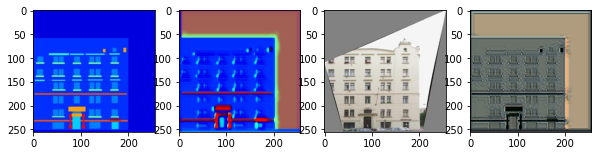

 18%|█▊        | 9/49 [1:47:32<7:58:04, 717.11s/it]

10 11.181350619792939 0.8527741744741797


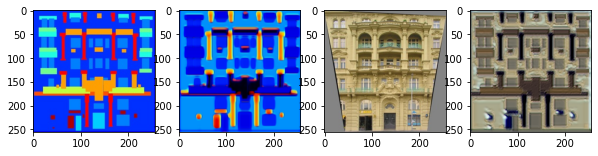

 20%|██        | 10/49 [1:59:30<7:46:11, 717.23s/it]

11 10.811556875705719 0.9030338916927576


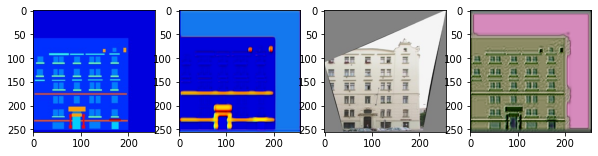

 22%|██▏       | 11/49 [2:11:27<7:34:16, 717.29s/it]

12 12.464385042190552 0.7531727040931583


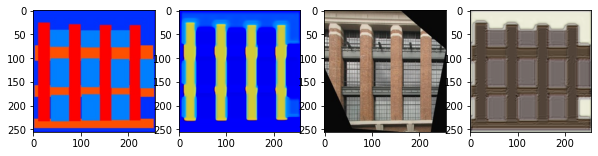

 24%|██▍       | 12/49 [2:23:25<7:22:25, 717.44s/it]

13 12.4338183927536 0.7622398400679231


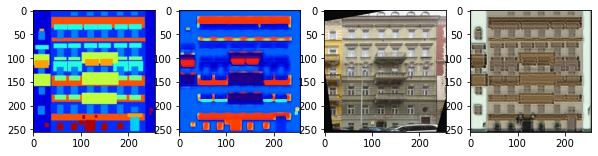

 27%|██▋       | 13/49 [2:35:23<7:10:33, 717.59s/it]

14 11.372898774147034 0.8303506636619568


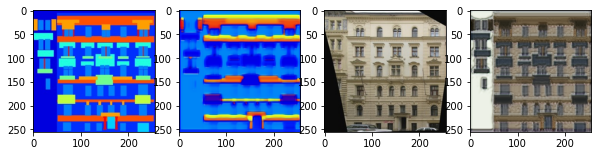

 29%|██▊       | 14/49 [2:47:21<6:58:41, 717.76s/it]

15 11.152439303398133 0.8759360722452402


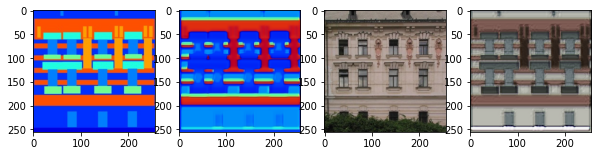

 31%|███       | 15/49 [2:59:20<6:46:50, 717.94s/it]

16 11.02085881471634 0.850909826233983


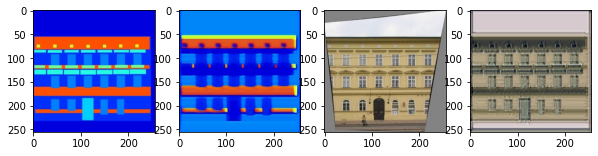

 33%|███▎      | 16/49 [3:11:18<6:34:59, 718.18s/it]

17 12.280787937641144 0.7967178040742874


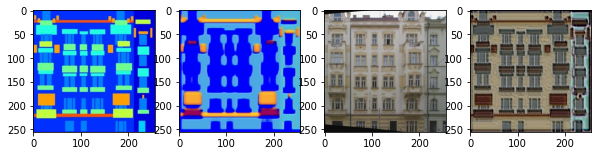

 35%|███▍      | 17/49 [3:23:17<6:23:07, 718.35s/it]

18 13.315868372917175 0.736503207422793


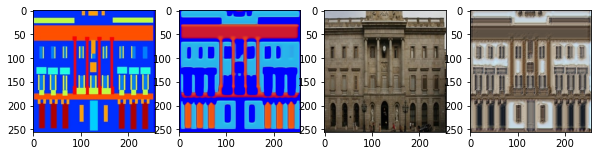

 37%|███▋      | 18/49 [3:35:16<6:11:12, 718.46s/it]

19 12.928229451179504 0.6958456363528966


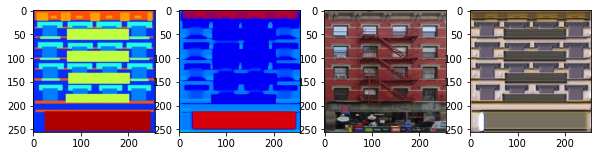

 39%|███▉      | 19/49 [3:47:14<5:59:14, 718.48s/it]

20 13.31850929737091 0.7171270123869181


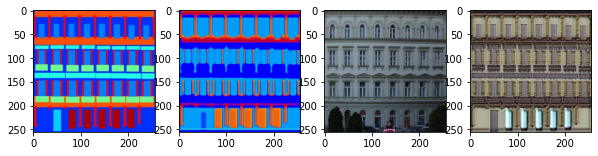

 41%|████      | 20/49 [3:59:13<5:47:15, 718.46s/it]

21 12.817165613174438 0.76012097671628


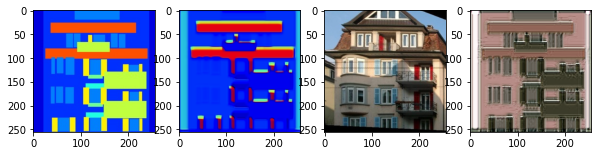

 43%|████▎     | 21/49 [4:11:12<5:35:22, 718.66s/it]

22 12.729934403896332 0.6974454542994499


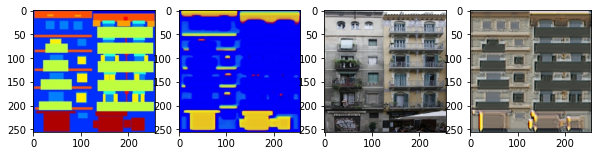

 45%|████▍     | 22/49 [4:23:11<5:23:27, 718.80s/it]

In [ ]:
%%time
for i_epoch in tqdm.tqdm(range(1, 50)):
    loss_g, loss_d = model_cycle_gan.train_epoch(train_dataloader)
    print(i_epoch, loss_g, loss_d)

    with torch.no_grad():
        model_cycle_gan.Gx.eval()
        model_cycle_gan.Gy.eval()
        x, y = val_dataset[random.randrange(len(val_dataset))]
        y_fake = model_cycle_gan.Gx(x.unsqueeze(0).to(device))
        x_fake = model_cycle_gan.Gy(x.unsqueeze(0).to(device))
        display_progress(x, x_fake[0], y, y_fake[0])